<font size="4"> <b> • DOMAIN: </b> Face recognition</font>

<font size="4"> <b> • CONTEXT: </b> Company X intends to build a face identification model to recognise human faces.

<font size="4"> <b> • DATA DESCRIPTION: </b>The dataset comprises of images and its mask where there is a human face

  

<font size="4"> <b> • PROJECT OBJECTIVE: </b> Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

<b>TASK:</b>In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project
    
   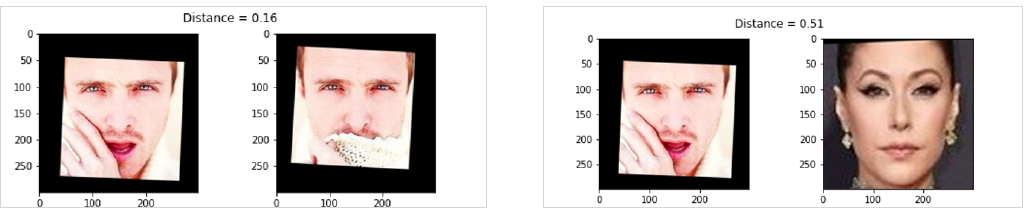
 
<b>1. Load the dataset and create the metadata</b>

<b>2. Check some samples of metadata.</b>

<b>3. Load the pre-trained model and weights.</b>

<b>4. Generate Embedding vectors for each face in the dataset.</b>
    
<b>5. Build distance metrics for identifying the distance between two given images.</b>
    
<b>6. Use PCA for dimensionality reduction</b>
    
<b>7. Build an SVM classifier in order to map each image to its right person.</b>
    
<b>8. Import the the test image. Display the image. Use the SVM trained model to predict the face.</b>

In [241]:
import pandas as pd
import io
from google.colab import files
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob
import math
import tensorflow as tf
from tensorflow import keras

In [242]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change current working directory to project folder. [ Score: 2 points ]

In [243]:
project_path = "/content/drive/MyDrive/Colab Notebooks"

#### Extract the zip file [ Score: 2 points ]
- Extract Aligned Face Dataset from Pinterest.zip

In [244]:
from zipfile import ZipFile
with ZipFile(project_path+'/Part 3 - Aligned Face Dataset from Pinterest.zip', 'r') as z:
  z.extractall()

In [245]:
path = '/content/pins/PINS/*/*.jpg' 

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [246]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [247]:
metadata.shape

(10770,)

### Define function to load image
- Define a function to load image from the metadata

In [248]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image [ Score: 2 points ]
- Load one image using the function "load_image"

In [249]:
a =  load_image("/content/pins/PINS/pins_Aaron Paul/Aaron Paul0_262.jpg")

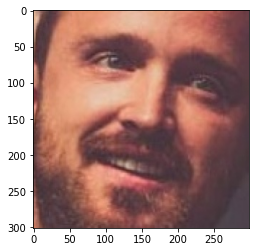

In [250]:
plt.imshow(a)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model [ Score: 2 points ]
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [252]:
from keras.models import model_from_json

model = vgg_face()
# Pickle model to JSON
classifier_model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(classifier_model_json)
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Part 3 - vgg_face_weights.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [253]:
loaded_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [254]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

### Get vgg_face_descriptor

In [255]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=loaded_model.layers[0].input, outputs=loaded_model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [256]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


#### Generate embeddings for all images  [ Score: 3 points ]
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [257]:
embedding_vector

array([ 0.01269798,  0.01051456, -0.00708295, ..., -0.02460314,
        0.00812148,  0.02130083], dtype=float32)

In [258]:
embedding_vector.shape

(2622,)

In [259]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [260]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

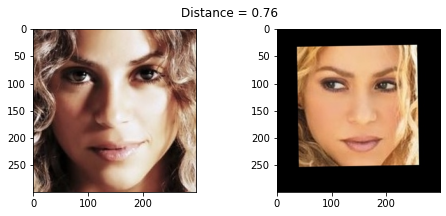

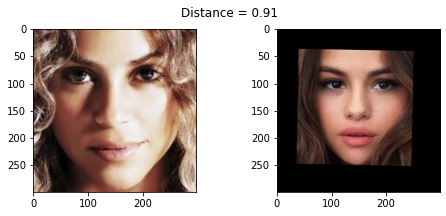

In [261]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

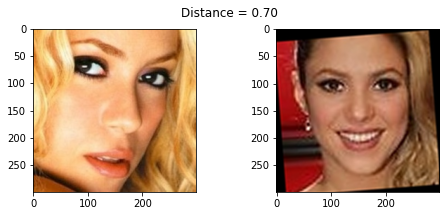

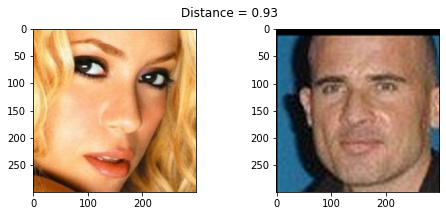

In [262]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(30, 31)
show_pair(30, 100)

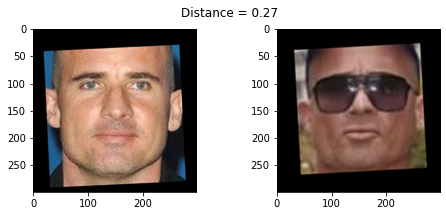

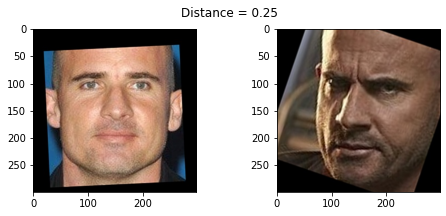

In [263]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(70, 72)
show_pair(70, 115)

#### Create train and test sets [ Score: 2 points ]
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [264]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [265]:
X_train

array([[ 0.01455198,  0.0058739 , -0.00071878, ..., -0.02403961,
         0.00758028,  0.0169657 ],
       [ 0.01491524,  0.00875747, -0.00702412, ..., -0.02821135,
         0.02394309,  0.04403234],
       [ 0.00310081,  0.01192329, -0.00284955, ..., -0.01933262,
         0.01967412,  0.03567045],
       ...,
       [-0.01079538,  0.01411171,  0.01463735, ..., -0.00945566,
         0.02003745,  0.02516155],
       [ 0.0027523 ,  0.01306826, -0.01693762, ...,  0.01810608,
         0.01241308,  0.04151267],
       [ 0.00043845,  0.02622683, -0.01028468, ..., -0.01474514,
         0.0084803 ,  0.02979707]])

In [266]:
X_test

array([[ 1.26979835e-02,  1.05145602e-02, -7.08295079e-03, ...,
        -2.46031396e-02,  8.12148117e-03,  2.13008318e-02],
       [-4.44277003e-03, -4.29888954e-03,  1.43888053e-02, ...,
        -3.27904262e-02,  9.86657571e-03,  9.99450218e-03],
       [ 1.50370761e-03, -6.22051442e-03, -6.42424566e-05, ...,
        -2.77825166e-02,  2.01568063e-02,  1.30309332e-02],
       ...,
       [ 1.03024312e-03,  1.64239518e-02,  2.25204602e-03, ...,
        -2.11692322e-02, -7.06786197e-03,  1.22606605e-02],
       [-1.69073860e-03,  7.60349818e-03, -5.58571611e-03, ...,
         1.42240489e-03,  9.33905970e-03,  3.43903229e-02],
       [ 6.35540113e-03, -1.63845401e-02, -2.37858407e-02, ...,
        -7.88358739e-04,  3.94338276e-03,  1.36094075e-02]])

In [267]:
y_train

array(['pins_shakira', 'pins_shakira', 'pins_shakira', ...,
       'pins_Natalie Portman ', 'pins_Natalie Portman ',
       'pins_Natalie Portman '], dtype='<U29')

In [268]:
y_test

array(['pins_shakira', 'pins_shakira', 'pins_shakira', ...,
       'pins_Natalie Portman ', 'pins_Natalie Portman ',
       'pins_Natalie Portman '], dtype='<U29')

In [269]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(9573, 2622)
(1197, 2622)
(1197,)
(9573,)


#### Encode the Labels  [ Score: 2 points ]
- Encode the targets
- Use LabelEncoder

In [270]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.fit_transform(y_test)

In [271]:
y_train

array([95, 95, 95, ..., 41, 41, 41])

In [272]:
y_test

array([95, 95, 95, ..., 41, 41, 41])

In [273]:
print(y_train.shape)
print(y_test.shape)

(9573,)
(1197,)


#### Standardize the feature values [ Score: 2 points ]
- Scale the features using StandardScaler

In [274]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# transform data

scaled_xtest = scaler.fit_transform(X_test)
scaled_xtrain = scaler.fit_transform(X_train)

print('Test',scaled_xtest,'\n\n')
print('Train', scaled_xtrain)

Test [[ 0.19437849  0.9067122  -0.95699949 ... -0.93981507  0.23035807
   0.57890586]
 [-1.55300811 -0.35399524  1.07659777 ... -1.6994382   0.39538477
  -0.25740643]
 [-0.94680399 -0.51753627 -0.29225525 ... -1.23480026  1.36849128
  -0.03280617]
 ...
 [-0.99507057  1.40963449 -0.07287879 ... -0.62121434 -1.20603818
  -0.08978209]
 [-1.27245668  0.65896454 -0.81519588 ...  1.4748562   0.34549967
   1.54711594]
 [-0.45220589 -1.38255172 -2.53893582 ...  1.26973974 -0.16474821
   0.00998271]] 


Train [[ 0.38980261  0.5252535  -0.34177789 ... -0.90277699  0.15172416
   0.26682176]
 [ 0.42790965  0.76971628 -0.94253503 ... -1.29573753  1.69125335
   2.35540528]
 [-0.8114573   1.03810669 -0.54479217 ... -0.45939836  1.28959897
   1.71016399]
 ...
 [-2.26920709  1.22363545  1.12131554 ...  0.4709694   1.32378324
   0.89925009]
 [-0.84801722  1.13517398 -1.88706774 ...  3.06716914  0.60642804
   2.16097589]
 [-1.09074626  2.25072592 -1.25319256 ... -0.02727734  0.23640452
   1.25694763]]


In [275]:
scaled_xtrain.shape

(9573, 2622)

In [276]:
scaled_xtest.shape

(1197, 2622)

In [277]:
y_train.shape

(9573,)

In [278]:
y_test.shape

(1197,)

#### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [279]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 128)
pca.fit(scaled_xtrain)
converted_data_train = pca.transform(scaled_xtrain)
converted_data_test = pca.transform(scaled_xtest)
 
print(converted_data_train.shape,'\n\n')
print(converted_data_test.shape)

(9573, 128) 


(1197, 128)


In [280]:

converted_data_train

array([[ 16.30162108, -13.29820384,   4.56464369, ...,  -2.77900504,
          0.82349736,  -0.05028573],
       [ 34.71321852,  -6.74163852,  10.55869135, ...,   2.17435062,
          0.85218387,  -0.69521135],
       [ 17.89560746,  -8.81101006,   2.54429449, ...,  -0.65443416,
         -1.63289111,   0.46232417],
       ...,
       [ 28.84591016,  -6.83553463,   6.10206233, ...,   0.09151973,
         -0.61641996,   2.02430672],
       [ 22.29181627,  -6.96280984, -13.36793115, ...,   1.14188003,
         -1.56117903,   1.08913586],
       [ 31.05350423,   4.28561155,  -0.37182556, ...,   1.12110819,
          0.26392721,   3.01717965]])

In [281]:
converted_data_test

array([[ 1.59720885e+01, -1.42424781e+01, -7.71236426e+00, ...,
         2.64815685e-01, -9.31265863e-01, -7.15136283e-01],
       [ 1.03991116e+01, -1.51994960e+01,  1.08402768e+01, ...,
        -7.66817956e-01, -8.78296969e-01, -1.87787043e+00],
       [ 1.63530955e+01, -1.84443974e+01,  4.97224723e-01, ...,
        -1.90680783e+00,  9.64916061e-01, -1.10367393e+00],
       ...,
       [ 1.19657380e+01, -2.38224144e+00, -9.63096272e-01, ...,
        -1.41464517e+00, -1.66887221e+00,  1.51644155e+00],
       [ 1.35974911e+01,  3.93271367e+00, -2.41349559e+00, ...,
        -7.30530669e-01, -4.70146770e-01,  1.36767128e-01],
       [ 2.49128614e+01,  2.09535357e+00, -1.76244127e+00, ...,
         7.71980694e-01,  5.29490042e-03,  8.72779661e-01]])

#### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [282]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

svc_model = SVC()

In [283]:
converted_data_train.shape

(9573, 128)

In [284]:
y_train.shape

(9573,)

In [285]:
svc_model.fit(converted_data_train, y_train)
prediction = svc_model.predict(converted_data_test)
prediction1 = svc_model.predict(converted_data_train)

In [286]:
print(svc_model.score(converted_data_train, y_train))
print(svc_model.score(converted_data_test, y_test))

0.9957171210696751
0.9707602339181286


In [287]:
labels = np.array([meta.name for meta in metadata])
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, prediction, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      0.90      0.95        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       1.00      0.93      0.96        14
           Anne Hathaway       1.00      1.00      1.00        13
     Barbara Palvin Face       0.89      1.00      0.94         8
      Bellamy Blake Face       1.00      0.93      0.96        14
    Benedict Cumberbatch       1.00      0.92      0.96        13
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.75      1.00      

#### Test results (2 marks)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

Text(0.5, 1.0, 'Actual: Dominic Purcell \n Predicted: Dominic Purcell')

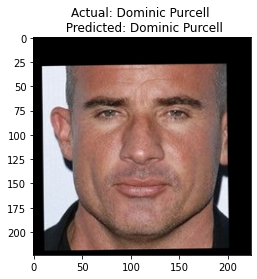

In [288]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

example_image = (example_image/255.).astype(np.float32)
example_image = cv2.resize(example_image, (224, 224))

embedding = vgg_face_descriptor.predict(np.expand_dims(example_image, axis = 0))[0]
embedding_scaled = scaler.transform(embedding.reshape(1, -1))

example_prediction = svc_model.predict(pca.transform(embedding_scaled))

example_identity = label_encoder.inverse_transform(example_prediction)[0].split('_')[-1].title().strip()

example_identity_actual = metadata[test_idx][example_idx].name.split('_')[-1].title().strip()

plt.imshow(example_image)
plt.title(f"Actual: {example_identity_actual} \n Predicted: {example_identity}")


* The VGG face model is pre trained with weights using which the embeddings for each image was generated in the dataset.

* After which, the distance between the images are calculated and lowest score represents more similar images. 

* The dataset is split into Train and Test, after which labels were encoded, the images are standardized and dimensionality reduction was performed using PCA. Here, 128 was the set dimensions.

* Classification model was designed using SVM and it is found that the test accuracy for the model is to be 95.6% which is extremely good.

* The classification scores and accuracy for all the images are calculated using a classification report.

* The 10th image from test set is plotted and image label is predicted to compare and see whether the prediction is accurate.

